<a href="https://colab.research.google.com/github/TatKhachatryan/Classification-Project/blob/main/Mobile_Price_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install -c conda-forge python-kaleido

✨🍰✨ Everything looks OK!
Solving environment: | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.



In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

### **Neccessary Funcitons**

In [3]:
def metric_results(y, y_pred):
    result =  pd.DataFrame({'Metric':['accuracy','sensitivity','specificity','precision','f1-score'],
            'Value':[metrics.accuracy_score(y, y_pred),
                     metrics.recall_score(y, y_pred,pos_label=0, average='macro'),
                     metrics.recall_score(y, y_pred, average='macro'),
                     metrics.precision_score(y, y_pred, average='macro'),
                     metrics.f1_score(y, y_pred, average='macro')]})
    result["Value"] = (result["Value"] * 100).round(2).astype(str) + '%'                            
    return result

### Data Processing

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/train.csv', header=0)
test = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/test.csv', header=0)

print("Train Size: ", train.shape)
print("Test Size: ", test.shape)

Train Size:  (2000, 21)
Test Size:  (1000, 21)


Dataset columns are as follows:

* **id** - ID
* **battery_power** - Total energy a battery can store in one time measured in mAh (milliampere hour - is 1000th of an ampere hour ( Ah ))
* **blue** - Has bluetooth or not
* **clock_speed** - Speed at which microprocessor executes instructions
* **dual_sim** - Has dual sim support or not
* **fc** - Front Camera mega pixels
* **four_g** - Has 4G or not
* **int_memory** - Internal Memory in Gigabytes
* **m_dep** - Mobile Depth in cm
* **mobile_wt** - Weight of mobile phone
* **n_cores** - Number of cores of processor
* **pc** - Primary Camera mega pixels
* **px_height** - Pixel Resolution Height
* **px_width** - Pixel Resolution Width
* **ram** - Random Access Memory in Megabytes
* **sc_h** - Screen Height of mobile in cm
* **sc_w** - Screen Width of mobile in cm
* **talk_time** - Longest time that a single battery charge will last when you are
* **three_g** - Has 3G or not
* **touch_screen** - Has touch screen or not
* **wifi** - Has wifi or not
* **price_range** - This is the target variable with value of:
** 0 (low cost)
** 1 (medium cost)
** 2 (high cost)
** 3 (very high cost)

# EDA

In [5]:
train.describe()
train['price_range'].unique()

array([1, 2, 3, 0])

So we have a multi-class classification problem.

Machine learning algorithm for multiclass classification:
* Decision Trees,
* k-Nearest Neighbors,
* Naive Bayes
* Support Vector Machine 

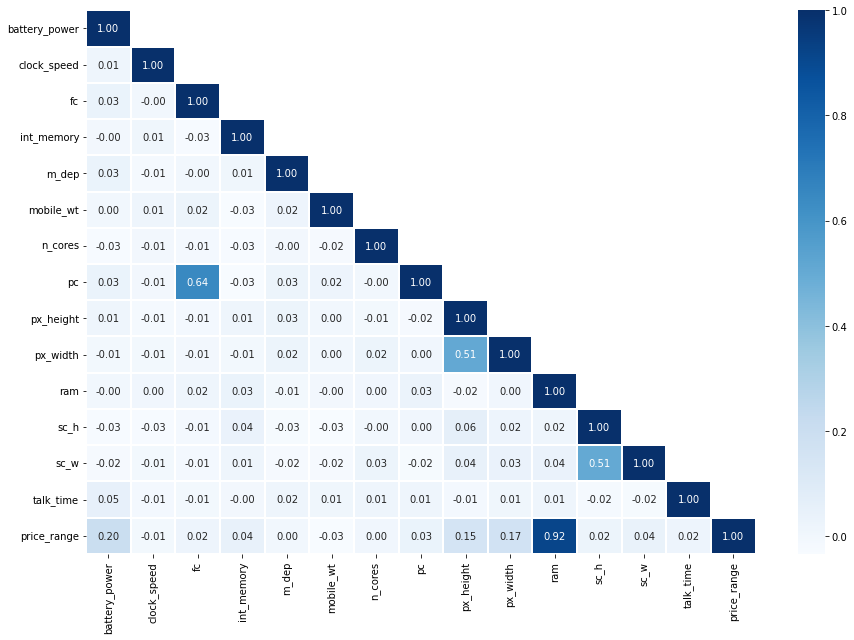

In [6]:
plt.figure(figsize = (15,10))

corr = train[['battery_power', 'clock_speed', 'fc',  'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
               'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'price_range']].corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

sns.heatmap(corr, annot=True, mask=mask, fmt='.2f', linewidths=0.2, cmap="Blues")
plt.show()

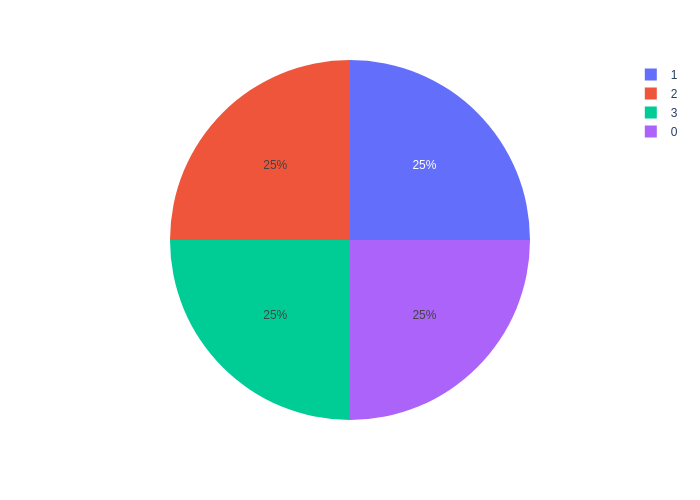

In [7]:
fig = px.pie(train, names = train['price_range'].value_counts().index, values = train['price_range'].value_counts().values)
fig.show(renderer="png")

So all the classes are equaly distributed.

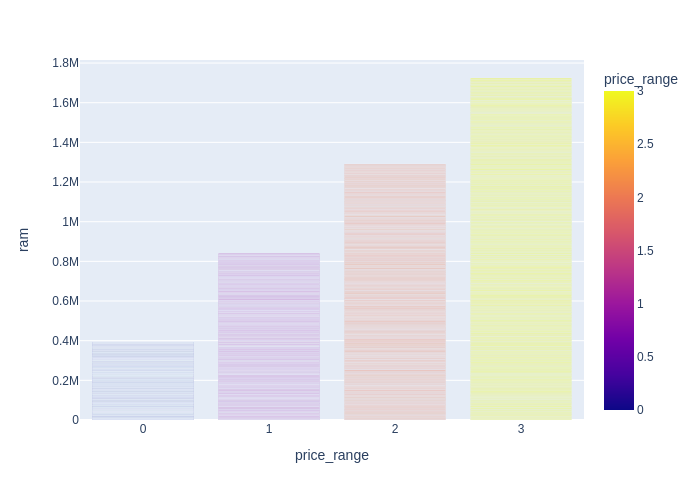

In [8]:
fig = px.bar(train, x='price_range', y='ram',  color='price_range')
fig.show(renderer="png")

This graph shows that when the ram gets higher, the price range gets higher too.

# Feature Importance
I'm going to choose most important features using RandomForestClassifier.

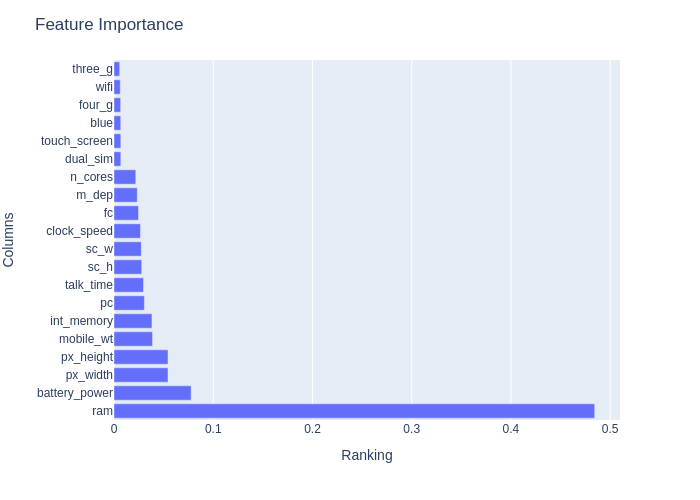

In [9]:
X = train.drop(['price_range'], axis=1)

y = train['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
ranking = np.argsort(-rf.feature_importances_)

fig = px.bar(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orientation='h')
fig.update_layout(title='Feature Importance',
                  xaxis_title="Ranking",
                  yaxis_title="Columns",)
fig.show(renderer="png")

We can see that from all the features "ram", "battery_power", "px_height" and "px_width" have the highest feature importance. To make our decision tree model not too complex and improve it's accuracy, I'll build my model based on these 4 features.

# Models. Decision Tree

In [10]:
# Filter dataset
selected_features = ["ram", "battery_power", "px_height", "px_width"]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0, min_samples_leaf=5)
clf_en.fit(X_train, y_train)
y_pred_en = clf_en.predict(X_test)

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))
y_pred_train_en = clf_en.predict(X_train)
y_pred_train_en

Model accuracy score with criterion entropy: 0.7550


array([1, 3, 1, ..., 1, 2, 1])

In [11]:
cm = confusion_matrix(y_test, y_pred_en)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[79 26  0  0]
 [ 4 73 14  0]
 [ 0 16 59 17]
 [ 0  0 21 91]]


In [12]:
# Generate classification report for training set

y_pred_train = clf_en.predict(X_train)
print("\n\t  Classification report for training set")
print("-"*55)
print(classification_report(y_train, y_pred_train))

# Generate classification report for test set
y_pred_test = clf_en.predict(X_test)
print("\n\t   Classification report for test set")
print("-"*55)
print(classification_report(y_test, y_pred_test))
print('\n')


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       395
           1       0.65      0.83      0.73       409
           2       0.72      0.61      0.66       408
           3       0.83      0.88      0.85       388

    accuracy                           0.77      1600
   macro avg       0.78      0.77      0.77      1600
weighted avg       0.78      0.77      0.77      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       105
           1       0.63      0.80      0.71        91
           2       0.63      0.64      0.63        92
           3       0.84      0.81      0.83       112

    accuracy                           0.76       400
   macro avg       0.76      0.75      0.75 

So here is the summary:



*   **precision** answers the following question: "How many of those that we predicted in a certain price range is actually in that range?"

*   **recall** shows how much was correctly identified as let's say 0 (low cost) to how much was actually 0. In this case, it answers the following question: "Of all the price ranges that we predicted (0, 1, 2, 3) how many did we correctly predict?"

*   **f1-score** is considered a better indicator of the classifier’s performance than the regular accuracy measure. It is the harmonic mean(average) of the precision and recall. The higher the F1 score the better, with 0 being the worst possible and 1 being the best.

*   **support** is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.











In [13]:
metric_results(y_test, y_pred_test)

,Metric,Value
0,accuracy,75.5%
1,sensitivity,75.21%
2,specificity,75.21%
3,precision,76.42%
4,f1-score,75.27%


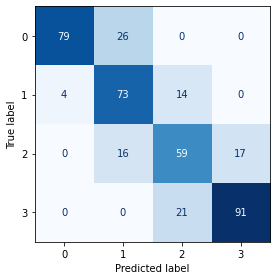

In [15]:
ConfusionMatrixDisplay.from_estimator(clf_en, X_test, y_test, colorbar=False, cmap='Blues')         
plt.tight_layout()
plt.show() 

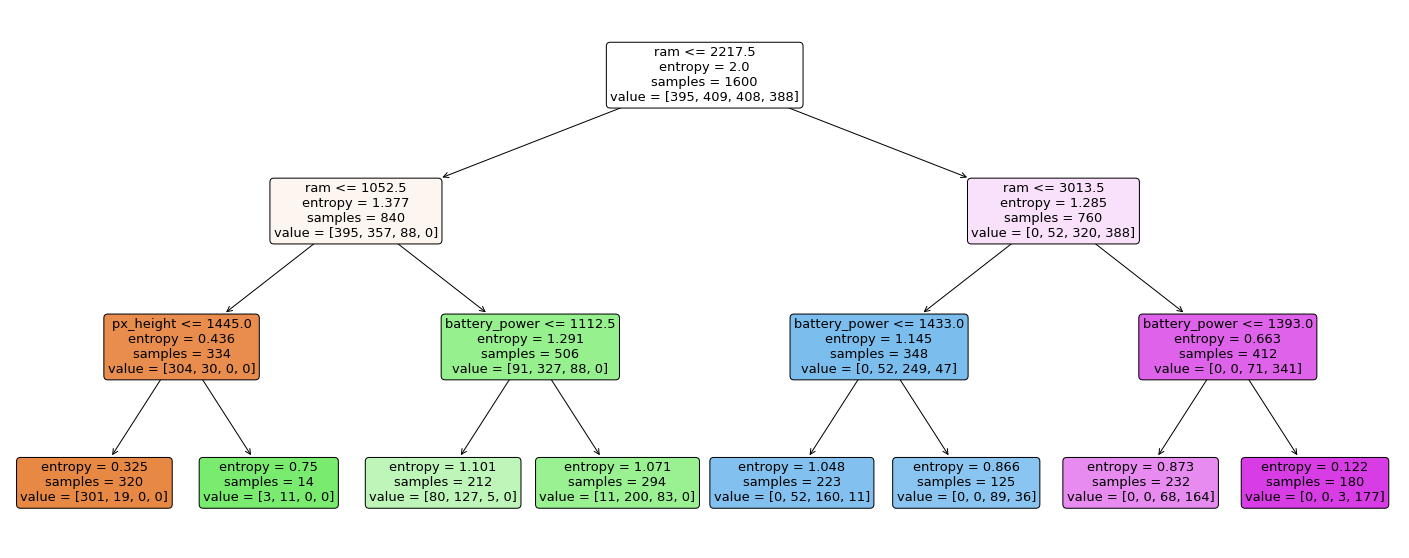

In [16]:
plt.figure(figsize=(25, 10))

fig = plot_tree(clf_en, filled=True, rounded=True, feature_names=X_train.columns, fontsize=13)

plt.show()

# Models. Support Vector Machine (SVM)

In [17]:
X = train.drop('price_range', axis=1)
y = train['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

**SVM** (Support Vector Machine) is a **distance-based** classifier. SVM works by finding the boundary that best separates the data into classes, while maximizing the margin (the distance between the boundary and the closest data points from each class, known as support vectors). This means that SVM is based on the concept of **distance** and seeks to find the optimal boundary that maximizes the distance between the classes. Therefore, **Standard Scaling** must be performed before model building:

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**Note:**
It is very important that StandardScaler transformation should only be learnt from the training set, otherwise it will lead to **data leakage.**

**SVM Hyperparameter Tuning:**

Hyperparameter tuning is important for SVM classifiers. SVM classifiers have several hyperparameters that need to be set before training the model, and the performance of the model can be highly sensitive to the values of these hyperparameters.

**SVM Classifier Hyperparameters:**


*   **C** - This hyperparameter controls the **regularization** strength of the model. C represents the penalty parameter for misclassification. It determines the tradeoff between achieving a low training error and a low testing error. A larger value of C allows the model to fit the training data more closely, which may result in better performance on the training set but may lead to overfitting and poor performance on new data. On the other hand, a smaller value of C encourages the model to have a larger margin and to be more tolerant of misclassifications, which can result in better generalization to new data.

*   **kernel** - This hyperparameter defines the type of kernel function used to transform the input data into a higher dimensional space where a linear boundary can be found. Common kernel functions include the linear, polynomial, rbf (radial basis function), sigmoid and precomputed kernels.

*   **gamma** - Kernel coefficient for rbf, poly and sigmoid kernels.

*   **degree** - This hyperparameter is only relevant when using the polynomial kernel. It defines the degree of the polynomial function used to transform the input data.

*   **decision_function_shape** - The decision_function_shape hyperparameter in SVM classifier specifies the strategy used to construct the multi-class decision function, and can take two values: ovr (one-vs-rest) and ovo (one-vs-one). The choice of strategy does not usually affect overall accuracy but can impact computational efficiency and interpretability. The ovr strategy is more computationally efficient but may lead to imbalanced class distributions, while the ovo strategy is more robust to noise and avoids imbalanced class distributions, but can be computationally expensive. The default value of 'ovr' is often used, and the choice of strategy is not a critical hyperparameter for most problems.





In [19]:
# to choose the best parameters I'm going to use a defined function which will return the best hyperparameters
def tune_hyperparameters(clf, param_grid, X_train, y_train):
  """
  Tunes the hyperparameters of a classifier using GridSearchCv and cross-validation.

  Parameters:
  ----------
  clf (estimator): A classifier object that imlements the estimator interface.
  param_grid (dict): A dictionary of hyperparameter values search over using GridSearchCV.
  X_train (array-like): The training input samples.
  y_train (array-like): The target values for the training input samples.

  Returns:
  estimator: The best classifier with the optimal hyperparameters.
  """

  # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Create GridSearchCV object
  clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

  # fit the GridSearchCV to the training set
  clf_grid.fit(X_train, y_train)

  # show the best hyperparameters
  print("Best hyperparameters:\n", clf_grid.best_params_)

  return clf_grid.best_estimator_
  

In [20]:
# defining the hyperparameters grid to search

param_grid = [{'kernel': ['poly'],
               'degree': [2, 3, 4, 5],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
              
              {'kernel': ['poly', 'sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
              
              {'kernel': ['linear'],
               'C': [0.01, 0.1, 1, 10, 100, 1000]}]

Tuning hyperparameters for Support Vector Machines

In [22]:
# svm_clf = svm.SVC(probability=True, random_state=42)

# svm_optimized = tune_hyperparameters(svm_clf, param_grid, X_train, y_train)

In [23]:
# linear kernel
linear = svm.SVC(kernel='linear', C=50, decision_function_shape='ovo').fit(X_train, y_train)

In [25]:
linear_pred = linear.predict(X_test)

In [26]:
metric_results(y_test, linear_pred)

,Metric,Value
0,accuracy,95.75%
1,sensitivity,95.69%
2,specificity,95.69%
3,precision,95.62%
4,f1-score,95.56%
